In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
#sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import regularizers
from IPython.core.display import display, HTML

2024-05-08 17:57:34.331100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 17:57:34.331205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 17:57:34.465220: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_24/3541373995.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')

In [3]:
data_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath, f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)

            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')


fpaths = pd.Series(filepaths, name= 'filepaths')
labelss = pd.Series(labels, name='labels')
df = pd.concat([fpaths, labelss], axis= 1) #filepaths + labels in 1 df
print(df['labels'].value_counts())

labels
Colon Adenocarcinoma            5000
Colon Benign Tissue             5000
Lung Adenocarcinoma             5000
Lung Squamous Cell Carcinoma    5000
Lung Benign Tissue              5000
Name: count, dtype: int64


In [4]:
df

filepaths                labels
0      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
1      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
2      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
3      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
4      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
...                                                  ...                   ...
24995  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24996  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24997  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24998  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24999  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue

[25000 rows x 2 columns]

In [5]:
#train test validation datset 
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state=42, stratify= strat)


strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state=42, stratify= strat)

In [6]:
height=224
width=224
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)

test batch size:  50   test steps:  50
Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [7]:
class_count

5

In [8]:
def image_griddy_boy(gen ):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

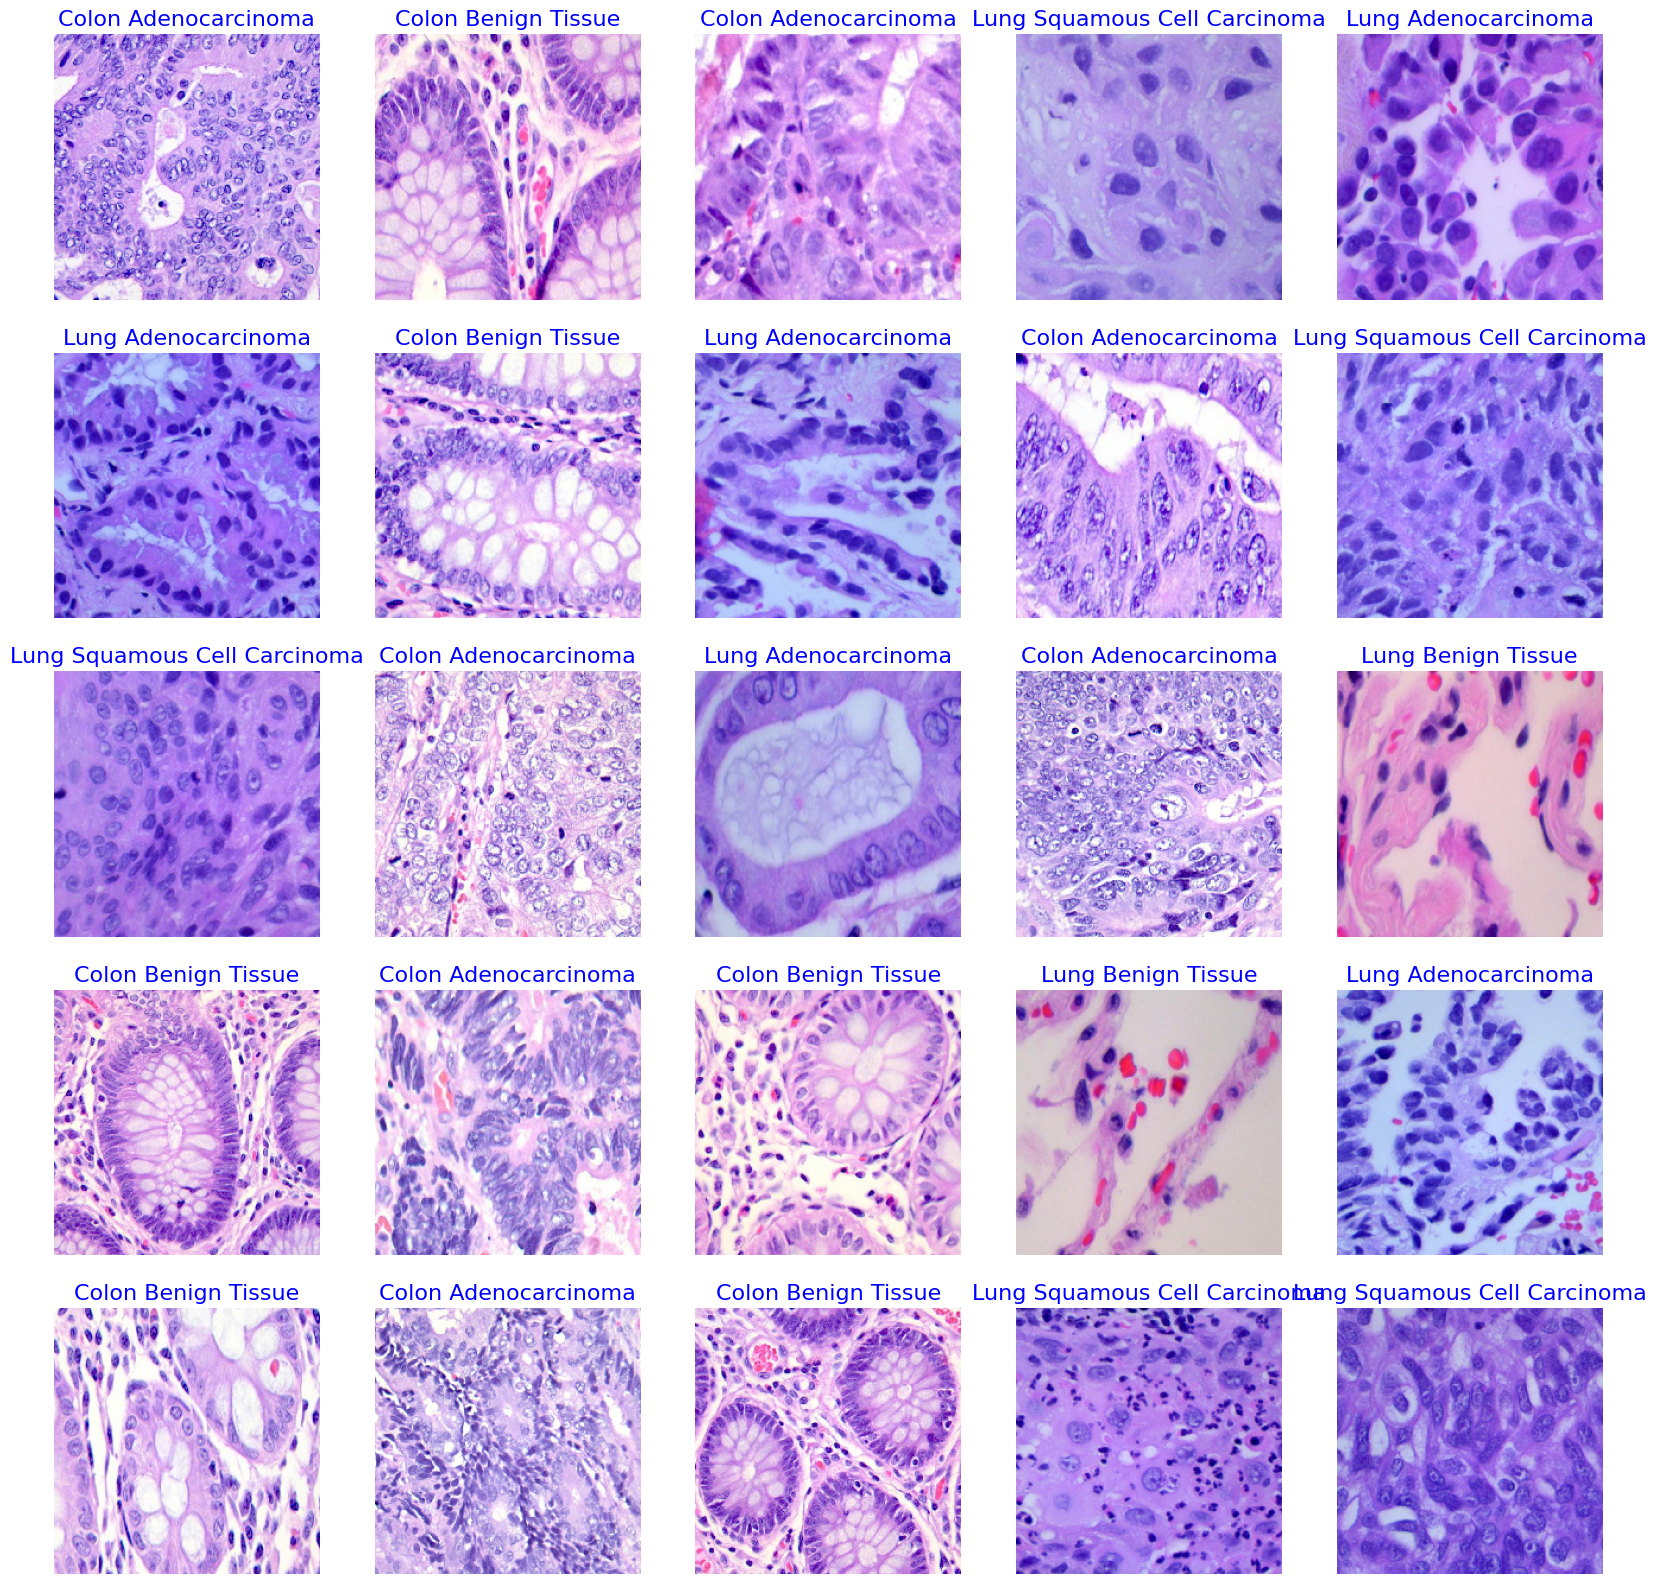

In [9]:
image_griddy_boy(train_gen)

filepaths  \
20441  /kaggle/input/lung-and-colon-cancer-histopatho...   
7937   /kaggle/input/lung-and-colon-cancer-histopatho...   
18472  /kaggle/input/lung-and-colon-cancer-histopatho...   
20710  /kaggle/input/lung-and-colon-cancer-histopatho...   
14118  /kaggle/input/lung-and-colon-cancer-histopatho...   
...                                                  ...   
2397   /kaggle/input/lung-and-colon-cancer-histopatho...   
13022  /kaggle/input/lung-and-colon-cancer-histopatho...   
22352  /kaggle/input/lung-and-colon-cancer-histopatho...   
15719  /kaggle/input/lung-and-colon-cancer-histopatho...   
21151  /kaggle/input/lung-and-colon-cancer-histopatho...   

                             labels  
20441            Lung Benign Tissue  
7937            Colon Benign Tissue  
18472  Lung Squamous Cell Carcinoma  
20710            Lung Benign Tissue  
14118           Lung Adenocarcinoma  
...                             ...  
2397           Colon Adenocarcinoma  
13022           Lung Adenocarcinoma  
22352            Lung Benign Tissue  
15719  Lung Squamous Cell Carcinoma  
21151            Lung Benign Tissue  

[2500 rows x 2 columns]

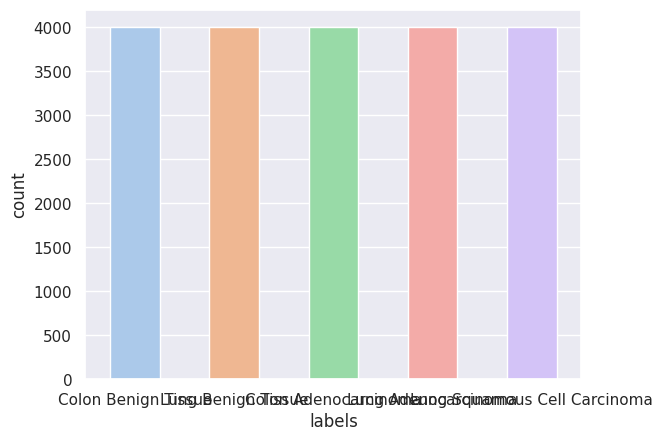

In [10]:
sns.countplot(train_df, x='labels',width=0.5)
#train_df
test_df

In [11]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# GLCM

In [12]:
def compute_glcm_features(image):
    distances = [1]  # You can experiment with different distances
    #angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # You can experiment with different angles
    glcm = graycomatrix(image, distances=distances, angles=[0], levels=256,
                        symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast').ravel()
    energy = graycoprops(glcm, 'energy').ravel()
    homogeneity = graycoprops(glcm, 'homogeneity').ravel()
    correlation = graycoprops(glcm, 'correlation').ravel()
    entropy = -np.sum(glcm * np.log(glcm + 1e-10))  # Compute entropy manually
    return np.concatenate((contrast, energy, homogeneity, correlation, [entropy]))

In [13]:
def load_and_compute_glcm_features(paths):
    features = []
    for path in paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        glcm_features = compute_glcm_features(image)
        features.append(glcm_features)
    return np.array(features)

In [14]:
X_features = load_and_compute_glcm_features(train_df['filepaths'])

In [15]:
X_features.shape

(20000, 5)

In [16]:
X_features

array([[5.50616037e+01, 2.90409453e-02, 2.74954254e-01, 9.88310250e-01,
        8.13417070e+00],
       [1.75093930e+01, 6.12387795e-02, 4.58173364e-01, 9.94601506e-01,
        7.03394516e+00],
       [6.89728820e+00, 8.11799620e-02, 5.78176786e-01, 9.97100490e-01,
        6.26818917e+00],
       ...,
       [1.50566839e+01, 5.88277088e-02, 4.44841848e-01, 9.94713426e-01,
        7.01799110e+00],
       [1.13285647e+01, 8.69739808e-02, 5.50917588e-01, 9.96649348e-01,
        6.39961493e+00],
       [8.79673410e+00, 4.52511178e-02, 4.82391827e-01, 9.97357073e-01,
        7.04888421e+00]])

In [17]:
columns = []
 # Each GLCM feature set consists of 5 features (contrast, energy, homogeneity, correlation, entropy)
columns.extend(["Contrast", "Energy", "Homogeneity", "Correlation", "Entropy"])

df_train = pd.DataFrame(X_features, columns=columns)

In [18]:
df_train

Contrast    Energy  Homogeneity  Correlation   Entropy
0      55.061604  0.029041     0.274954     0.988310  8.134171
1      17.509393  0.061239     0.458173     0.994602  7.033945
2       6.897288  0.081180     0.578177     0.997100  6.268189
3       6.354100  0.071892     0.550908     0.998242  6.666135
4      65.536333  0.023703     0.245572     0.982202  8.201482
...          ...       ...          ...          ...       ...
19995  20.308224  0.051181     0.418253     0.993802  7.241939
19996  12.969011  0.032188     0.407631     0.996315  7.472126
19997  15.056684  0.058828     0.444842     0.994713  7.017991
19998  11.328565  0.086974     0.550918     0.996649  6.399615
19999   8.796734  0.045251     0.482392     0.997357  7.048884

[20000 rows x 5 columns]

In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train_df['labels'])

# Model Creation

# XGBoost

In [20]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

# Step 3: Define a pipeline for preprocessing and training the model
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling (optional)
    ('classifier', xgb.XGBClassifier())  # XGBoost Classifier
])

# Step 4: Define hyperparameters to search over
param_grid_xgb = {
    'classifier__n_estimators': [3000, 1000, 500],
    'classifier__max_depth': [10, 15, 7],
    'classifier__learning_rate': [0.5, 0.3, 0.2]
}

# Step 5: Perform grid search cross-validation with k-fold cross-validation
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, n_jobs=-1)
grid_search_xgb.fit(X_features, y_encoded)

# Step 6: Get the best model and evaluate its performance
best_model_xgb = grid_search_xgb.best_estimator_
mean_cv_accuracy_xgb = grid_search_xgb.best_score_
print("Best Model Parameters (XGBoost):", grid_search_xgb.best_params_)
print("Mean Cross-Validation Accuracy (XGBoost):", mean_cv_accuracy_xgb)

Best Model Parameters (XGBoost): {'classifier__learning_rate': 0.5, 'classifier__max_depth': 7, 'classifier__n_estimators': 1000}
Mean Cross-Validation Accuracy (XGBoost): 0.92835


In [21]:
X_test_features = load_and_compute_glcm_features(test_df['filepaths'])

# Test data predictions

In [22]:
y_pred = best_model_xgb.predict(X_test_features)

In [23]:
test_labels_encoded=label_encoder.transform(test_df['labels'])

# Confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
# Compute the classification report
report = classification_report(test_labels_encoded, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       500
           1       0.93      0.93      0.93       500
           2       0.90      0.89      0.89       500
           3       0.97      0.98      0.97       500
           4       0.92      0.92      0.92       500

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500



<Figure size 800x600 with 0 Axes>

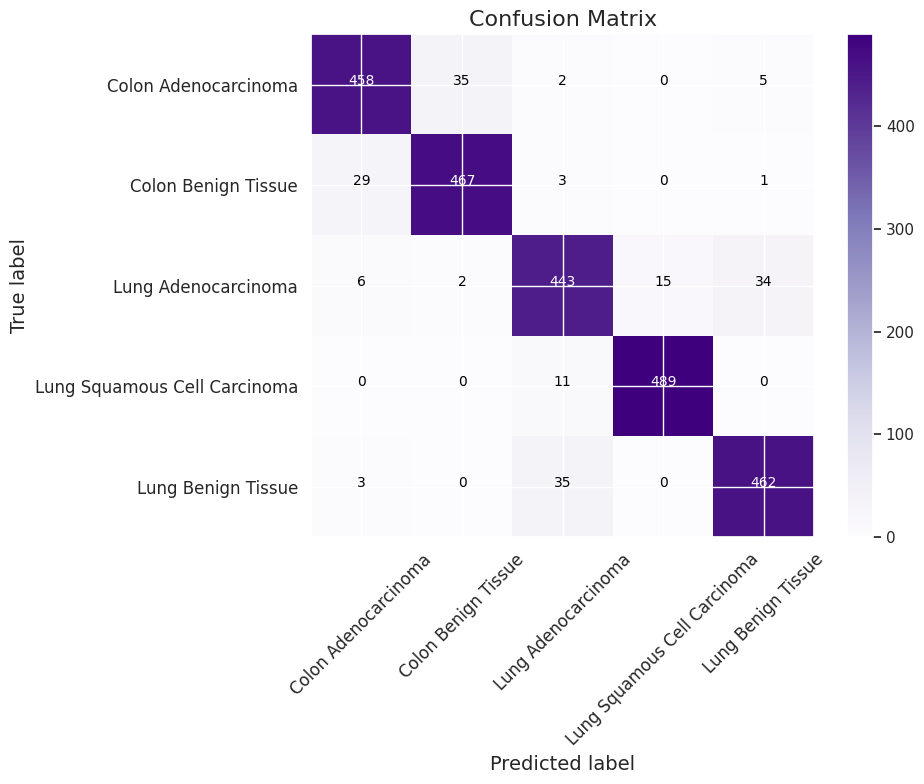

In [25]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

class_names = ['Colon Adenocarcinoma','Colon Benign Tissue','Lung Adenocarcinoma','Lung Squamous Cell Carcinoma','Lung Benign Tissue']
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Purples):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = 'd'
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black",
                 fontsize=10)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()

# Example confusion matrix
cm = confusion_matrix(test_labels_encoded, y_pred)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, class_names)
plt.show()


# RandomForestClassifier

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Step 3: Define a pipeline for preprocessing and training the model
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling (not necessarily required for RandomForestClassifier)
    ('classifier', RandomForestClassifier())  # Random Forest Classifier
])

# Define hyperparameters for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'classifier__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    # Add more hyperparameters as needed
}

# Step 5: Perform grid search cross-validation with k-fold cross-validation
grid_search_rf = GridSearchCV(rf_pipeline, param_grid, n_jobs=-1)
grid_search_rf.fit(X_features, y_encoded)

# Step 6: Get the best model and evaluate its performance
best_model_rf = grid_search_rf.best_estimator_
mean_cv_accuracy_rf = grid_search_rf.best_score_
print("Best Model Parameters (Random Forest):", grid_search_rf.best_params_)
print("Mean Cross-Validation Accuracy (Random Forest):", mean_cv_accuracy_rf)


Best Model Parameters (Random Forest): {'classifier__max_depth': 30, 'classifier__n_estimators': 300}
Mean Cross-Validation Accuracy (Random Forest): 0.9212


In [27]:
y_pred_GNB = best_model_rf.predict(X_test_features)

# Confusion Matrix

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
# Compute the classification report
report = classification_report(test_labels_encoded, y_pred_GNB)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       500
           1       0.91      0.94      0.92       500
           2       0.91      0.90      0.90       500
           3       0.96      0.99      0.98       500
           4       0.93      0.92      0.93       500

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500



<Figure size 800x600 with 0 Axes>

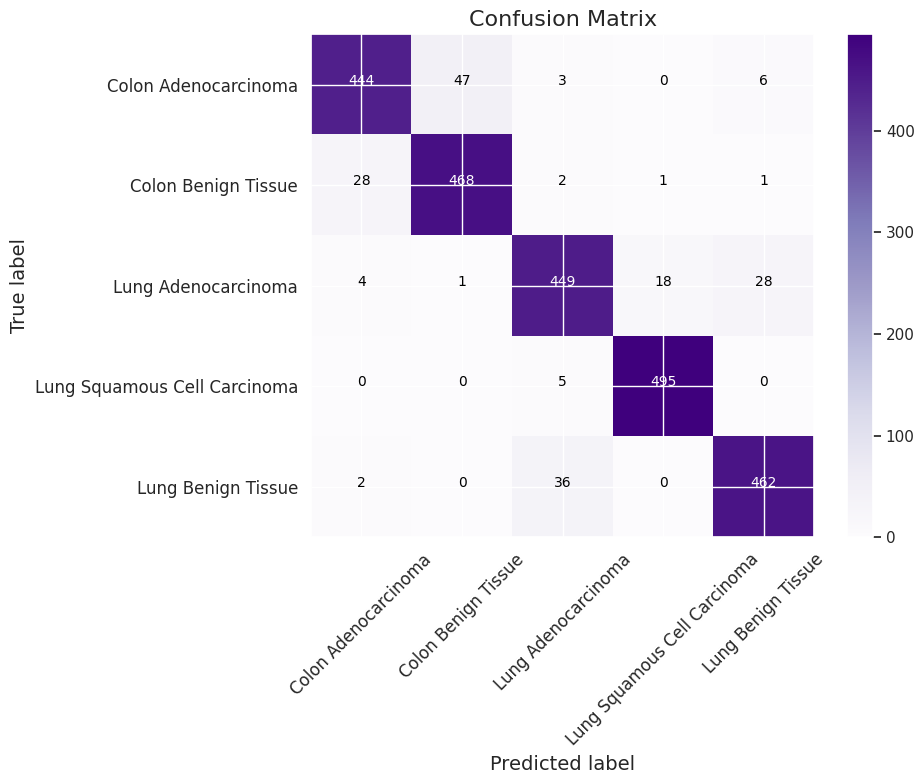

In [29]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, cmap=plt.cm.Purples):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = 'd'
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black",
                 fontsize=10)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()

# Example confusion matrix
cm = confusion_matrix(test_labels_encoded, y_pred_GNB)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, class_names)
plt.show()


# SVM

In [30]:
from sklearn.svm import SVC
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('classifier', SVC())  # Support Vector Classifier
])

# Step 4: Define hyperparameters to search over
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto']
}

# Step 5: Perform grid search cross-validation with k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=kf, n_jobs=-1)
grid_search_svm.fit(X_features, y_encoded)

# Step 6: Get the best model and evaluate its performance
best_model_svm = grid_search_svm.best_estimator_
mean_cv_accuracy_svm = grid_search_svm.best_score_
print("Best Model Parameters (SVM):", grid_search_svm.best_params_)
print("Mean Cross-Validation Accuracy (SVM):", mean_cv_accuracy_svm)

Best Model Parameters (SVM): {'classifier__C': 10, 'classifier__gamma': 'scale'}
Mean Cross-Validation Accuracy (SVM): 0.8836999999999999


In [31]:
y_pred_SVM = best_model_svm.predict(X_test_features)

# Confusion Matrix

In [32]:
# Compute the classification report
report = classification_report(test_labels_encoded, y_pred_SVM)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       500
           1       0.86      0.95      0.90       500
           2       0.83      0.80      0.82       500
           3       0.91      0.97      0.94       500
           4       0.87      0.87      0.87       500

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500



<Figure size 800x600 with 0 Axes>

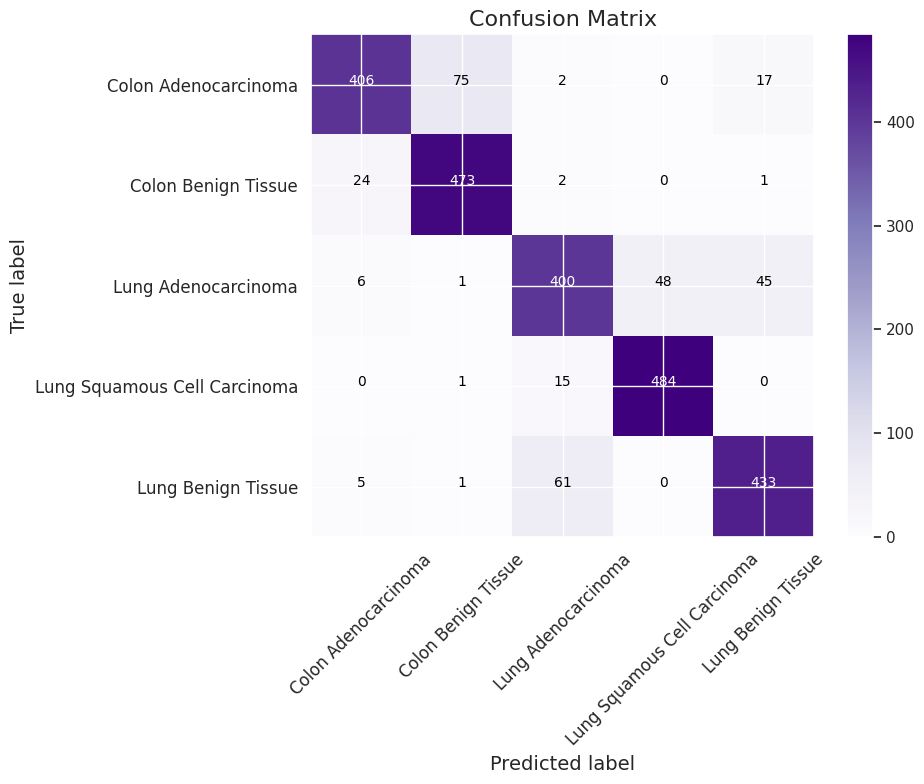

In [33]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, cmap=plt.cm.Purples):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = 'd'
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black",
                 fontsize=10)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()

# Example confusion matrix
cm = confusion_matrix(test_labels_encoded, y_pred_SVM)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, class_names)
plt.show()
